In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import cartopy.crs as ccrs
import cartopy

In [4]:
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

In [5]:
import dask

In [6]:
def convert_longitude_360to180(ds):
    """Convert ds from 0 to 360 longitude to -180 to 180 coordinate

    Parameters
    ----------
    ds: xr.Dataset
        CMIP model dataset

    Returns
    -------
    ds: xr.Dataset
        Same CMIP dataset with converted longitude
    """
    ds = ds.assign_coords({'lon': ds.lon.where(ds.lon <= 180, ds.lon - 360)})
    # To silence large chunk warning
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.sortby(ds.lon)
    return ds

## Global loading

In [7]:
mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR'], 'tas', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [8]:
mmle.compute_x(x_type='quantile_return', load=True, name='default_quantile_return_10yr')

Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/MIROC6.zarr
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/cesm_lens.zarr
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/CanESM5.zarr
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/MPI-ESM1-2-LR.zarr


In [9]:
mmle.compute_LE()

In [11]:
mmle_loaded = MultiModelLargeEnsemble('cmip6', 'tas', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario='ssp585',
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/tas.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp585/day/tas.zarr


In [12]:
save_name = f'gcs://{mmle_loaded.bucket}/{mmle_loaded.path}/all_scenarios_x/cmip6.zarr'
mmle_loaded.x = xr.open_zarr(save_name, consolidated=True)[mmle_loaded.variable]

In [13]:
mmle_loaded.x.model # in theory, we should only take the models that correspond, but there are only two

<xarray.DataArray 'model' (model: 14)>
array(['INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G', 'IITM-ESM', 'CMCC-ESM2',
       'CMCC-CM2-SR5', 'EC-Earth3', 'MIROC6', 'IPSL-CM6A-LR',
       'EC-Earth3-Veg-LR', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'GFDL-ESM4',
       'NorESM2-MM'], dtype='<U30')
Coordinates:
  * model     (model) <U30 'INM-CM4-8' 'INM-CM5-0' ... 'GFDL-ESM4' 'NorESM2-MM'
    quantile  float64 ...

In [14]:
mmle_loaded.x.sel(model=mmle_loaded.x.model.isin(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR'])).model
#  in theory, we should only take the models that correspond, but there are only two

<xarray.DataArray 'model' (model: 2)>
array(['MIROC6', 'MPI-ESM1-2-LR'], dtype='<U30')
Coordinates:
  * model     (model) <U30 'MIROC6' 'MPI-ESM1-2-LR'
    quantile  float64 ...

In [15]:
mmle.results['S_fit'] = mmle_loaded.x.mean('model').var('scenario').isel(member_id=0)

In [16]:
mmle.results['T_LE'] = mmle.results['S_fit'] +mmle.results['M_LE'] + mmle.results['Ibar_LE']

In [17]:
mmle.results['frac_M_LE'] = mmle.results['M_LE'] / (mmle.results['T_LE'])
mmle.results['frac_Ibar_LE'] = mmle.results['Ibar_LE'] / (mmle.results['T_LE'])
mmle.results['frac_S_LE'] = mmle.results['S_fit'] / (mmle.results['T_LE'])

In [18]:
mmle.results['frac_M_LE'].load()
mmle.results['frac_Ibar_LE'].load()
mmle.results['frac_S_LE'].load()

/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/carla/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/carla/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/carla/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return fun

<xarray.DataArray 'frac_S_LE' (time: 181, lat: 71, lon: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    member_id  <U8 'r1i1p1f1'

In [19]:
results  = convert_longitude_360to180(mmle.results)

In [21]:
results.load()

/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:       (time: 181, lat: 71, lon: 144, model: 4)
Coordinates:
  * time          (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat           (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon           (lon) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
  * model         (model) <U13 'MIROC6' 'cesm_lens' 'CanESM5' 'MPI-ESM1-2-LR'
    q_values      (model, lat, lon) float64 265.5 265.7 265.8 ... 273.8 273.8
    quantile      (model) float64 0.9997 0.9997 0.9997 0.9997
    member_id     <U8 'r1i1p1f1'
Data variables:
    M_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    I_LE          (model, time, lat, lon) float64 nan nan nan ... nan nan nan
    Ibar_LE       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    S_fit         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_M_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_Ibar_LE  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_S_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [22]:
time_1 = slice('2005', '2014')
time_2 = slice('2035', '2044')
time_3 = slice('2065', '2075')

data = [
results['frac_Ibar_LE'].sel(time=time_1).mean('time'),
results['frac_M_LE'].sel(time=time_1).mean('time'),
results['frac_S_LE'].sel(time=time_1).mean('time'),

results['frac_Ibar_LE'].sel(time=time_2).mean('time'),
results['frac_M_LE'].sel(time=time_2).mean('time'),
results['frac_S_LE'].sel(time=time_2).mean('time'),

results['frac_Ibar_LE'].sel(time=time_3).mean('time'),
results['frac_M_LE'].sel(time=time_3).mean('time'),
results['frac_S_LE'].sel(time=time_3).mean('time'),

]

In [23]:
results = mmle.results

orig_map=plt.cm.RdYlBu
reversed_map = orig_map.reversed()

regions = ['USeast','USwest','iceland','europe','australia','tropics']
proj = ccrs.PlateCarree()
titles = [
    "Internal variability",
    "Model uncertainty",
    "Scenario uncertainty",
    None,
    None,
    None,
    None,
    None,
    None,
]
y_labels = [
    'Decade 0 \n(2005-2014)',
    None,
    None,
    'Decade 3 \n(2035-2044)',
    None,
    None,
    'Decade 6 \n(2065-2075)',
    None,
    None,
]

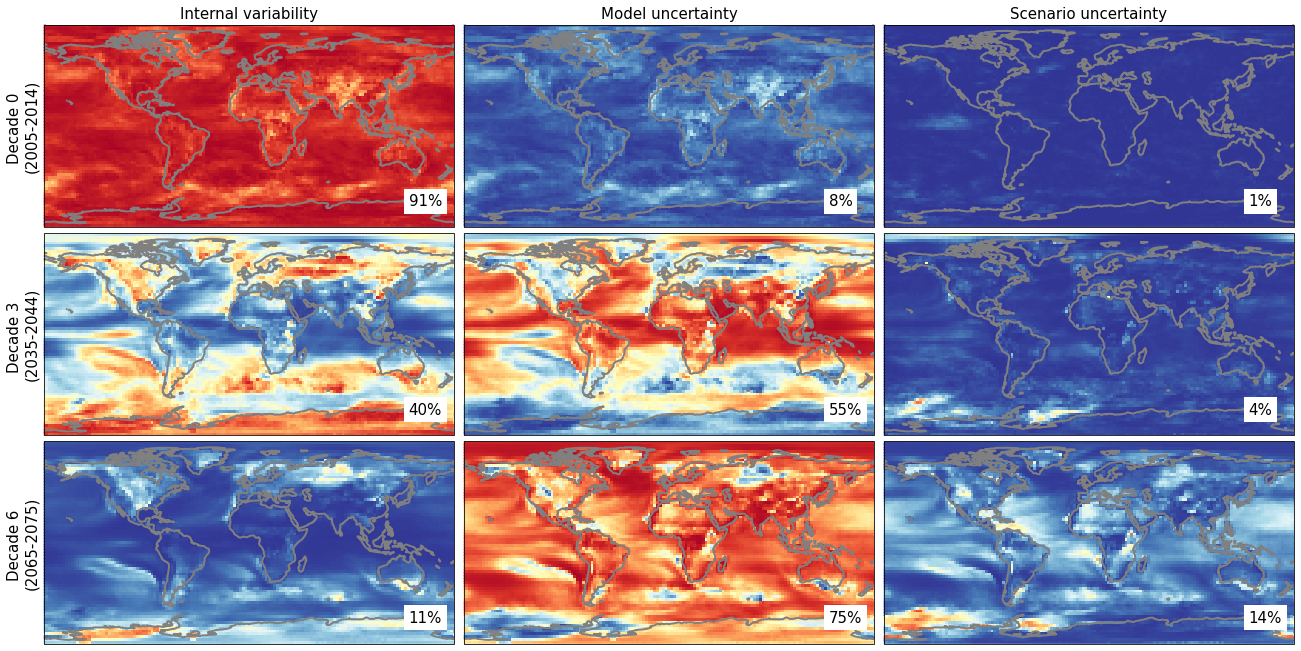

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

for ax, data_i, title, y_label in zip(axes.ravel(), data, titles, y_labels):
    percentage = int(np.round((data_i.mean(('lat', 'lon'))*100).values))
    data_i.plot(ax=ax, cmap=reversed_map, 
    vmin = 0, vmax = 1,
    add_colorbar=False,
    )
    ax.set_title(title, fontsize=15)
    ax.text(140, -70, f'{percentage}%', fontsize=15,
        bbox={'facecolor': 'white', 
            'alpha': 1, 'pad': 5, 
            'edgecolor' : 'none'})
    if y_label:
        ax.text(-0.01, 0.5, y_label, fontsize=15, va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes)
    ax.coastlines(linewidth=2, color='gray')

plt.subplots_adjust(left=0.2, bottom=0.02, wspace=0, hspace=0.03)
plt.show()

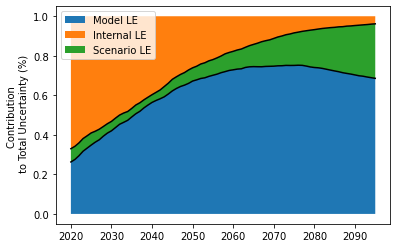

In [26]:
# plot total uncertainty (direct and indirect) 

x=results.sel(time=slice('2020', None)).time.values
y1=results['frac_M_LE'].mean(('lat', 'lon')).sel(time=slice('2020', None))

y2=y1 + results['frac_S_LE'].mean(('lat', 'lon')).sel(time=slice('2020', None))
plt.fill_between(x,0,y1,label='Model LE')
plt.plot(x,y1,color='k')
plt.plot(x,y2,color='k')

plt.fill_between(x,y2,1,label='Internal LE')
plt.fill_between(x,y1,y2,label='Scenario LE')

plt.ylabel('Contribution \n to Total Uncertainty (%)')
plt.legend()

In [ ]:
import os
import numpy as np
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


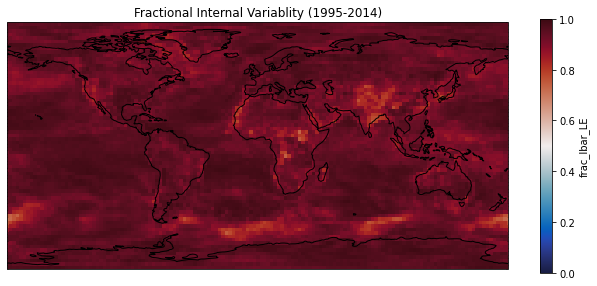

In [178]:
# Figure size
size = (9, 4)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('1995', '2014')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=True,
    
)
# Title

ax.set_ylabel('latitude')
plt.title('Fractional Internal Variablity (1995-2014)',fontsize=12)
# Add map features with Cartopy 
ax.coastlines(linewidth=1)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9836/2253931764.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


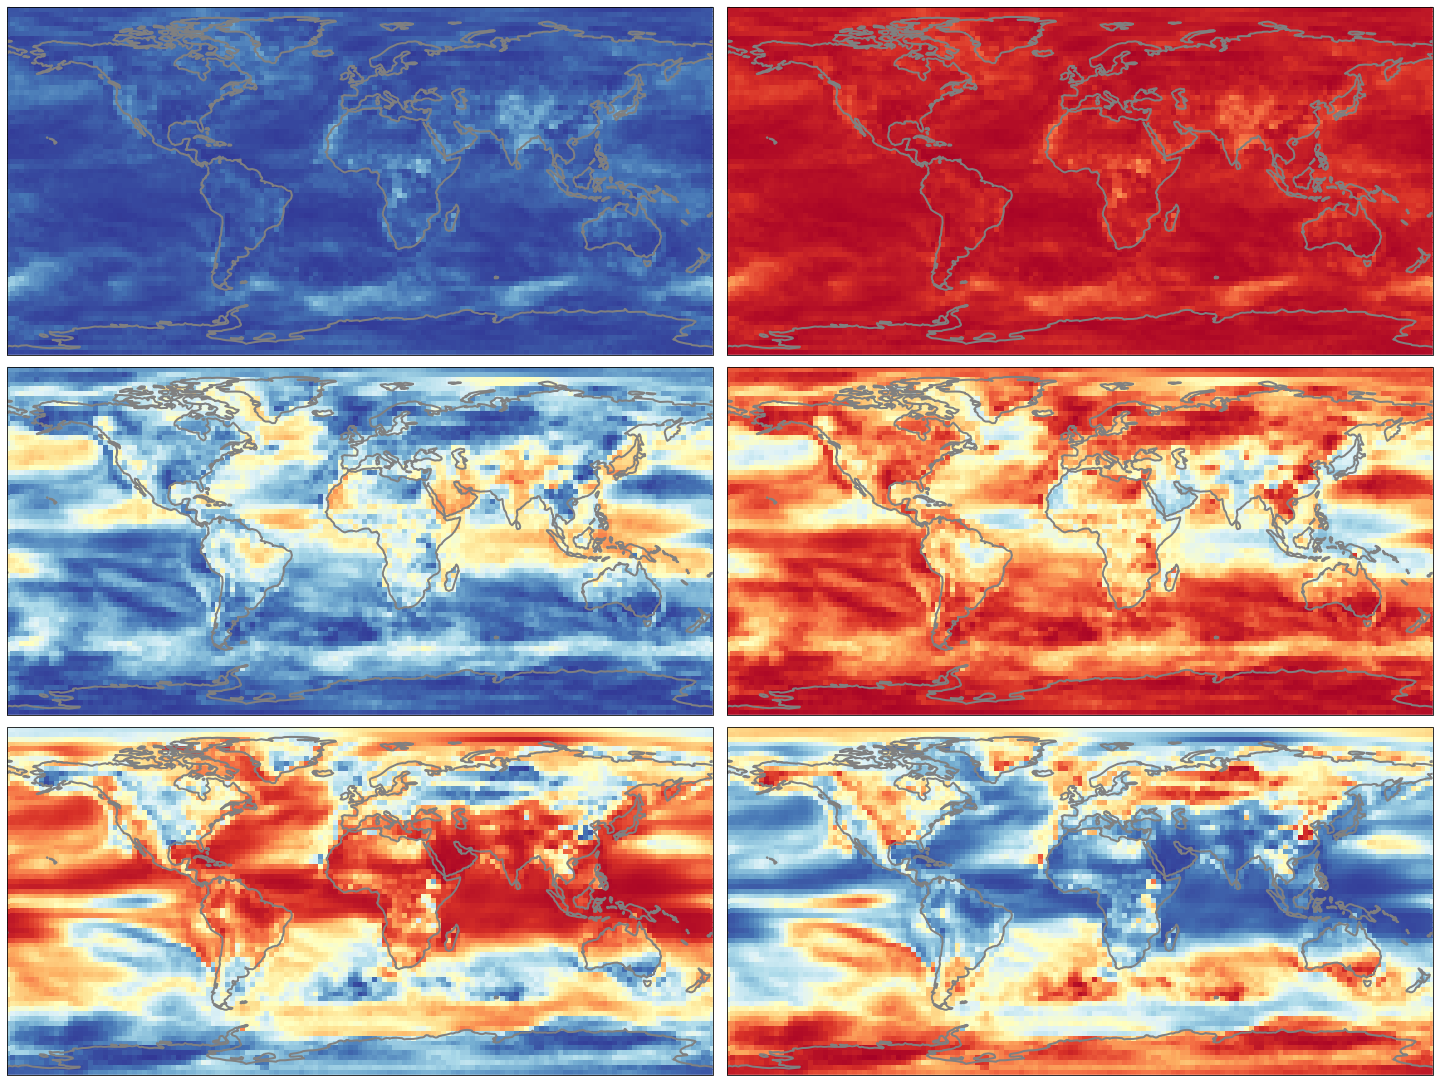

<Figure size 432x288 with 0 Axes>

In [202]:
# # Color bar


# Figure size
size = (10, 10)

# Color from cmocean
color = 'RdYlBu'

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(0,1,0.98,0.98))
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('1995', '2014')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Internal Variablity (1995-2014)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')


# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(1,1,0.98,0.98))
# and extent
air = results['frac_M_LE'].sel(time=slice('1995', '2014')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# plt.title('Fractional Model Uncertainty (1995-2014)', fontsize=12)
ax.coastlines(linewidth=2, color='gray')



# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(0,0.5,0.98,0.98))
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('2015', '2024')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Internal Variablity (2015-2024)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(1,0.5,0.98,0.98))
# and extent
air = results['frac_M_LE'].sel(time=slice('2015', '2024')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Model Variablity (2015-2024)',fontsize=12)


# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(0,0,0.98,0.98))
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('2035', '2044')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Internal Variablity (2035-2044)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(1,0,0.98,0.98))
# and extent
air = results['frac_M_LE'].sel(time=slice('2035', '2044')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Model Variablity (2035-2044)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')
# 
# cbar = fig.colorbar(cf, ax=ax, fraction=0.02,
#                     orientation="horizontal")
# cbar.ax.tick_params(labelsize=8)

# # Site Davies Reef
# ax.scatter(-10, 10, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())


plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()